# Predicting Main Failure and Using LIME and SHAP for Explainability

In this analysis, I will predict the **Main Failure** in drilling operations using an XGBoost model. To understand the model's predictions, I will use two explainability techniques:
1. **LIME (Local Interpretable Model-agnostic Explanations)**: To explain individual predictions and understand why the model made a specific decision for a single instance.
2. **SHAP (SHapley Additive exPlanations)**: To analyze global feature importance and understand how each feature contributes to the model's predictions across the entire dataset.

By combining LIME and SHAP, I aim to gain a deeper understanding of the model's behavior, both locally and globally, and identify the key factors driving predictions of drilling failures.

In [1]:
import pandas as pd

import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import shap
import lime
import lime.lime_tabular

import json

C:\Users\User\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/dataset_2_cleaned.csv')

In [3]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
X = df.drop(columns=['main_failure', 'BEF', 'CCF', 'FWF', 'WDF'])
y = df['main_failure']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [7]:
 # Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [8]:
# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

In [9]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.99825
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3816
           1       0.98      0.98      0.98       184

    accuracy                           1.00      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



# Model Performance Analysis

## ✅ **Accuracy**: `0.99825`
- The model correctly classified **99.825%** of the test samples.

## 🔹 **Classification Report**
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** (Negative Class) | `1.00` | `1.00` | `1.00` | `3816` |
| **1** (Positive Class) | `0.98` | `0.98` | `0.98` | `184` |

### 📌 **Key Metrics Explained**
- **Precision** = TP / (TP + FP)  
  - **Class 0:** `1.00` → No false positives, perfect classification.  
  - **Class 1:** `0.98` → 2% of predicted positives are incorrect.  
- **Recall** = TP / (TP + FN)  
  - **Class 0:** `1.00` → Captures all actual negatives correctly.  
  - **Class 1:** `0.98` → Misses **2%** of actual positives.  
- **F1-Score** = Harmonic mean of precision & recall  
  - **Balances false positives & false negatives** for both classes.  

##  **Overall Model Performance**
- **Macro Average (`0.99`)** → Equal weight for both classes.  
- **Weighted Average (`1.00`)** → Adjusted for class imbalance.  

✅ **Conclusion:** The model performs **exceptionally well**, with **high accuracy, precision, and recall**. 🚀  


In [10]:
#5 Fold Cross Validation 
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy:", scores.mean())

Cross-validation accuracy: 0.99875


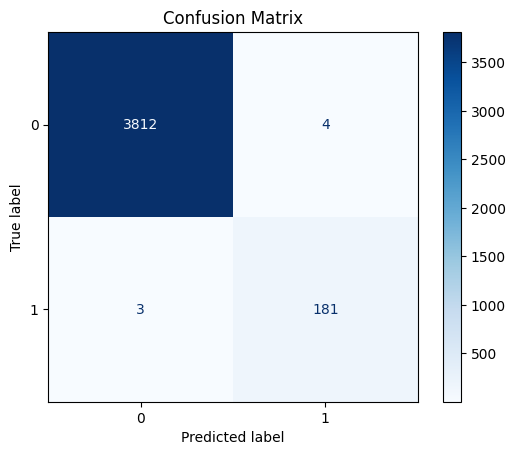

In [11]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

plt.savefig('../results/result_2/ConfusionMatrix_Prediction.png')
plt.show()


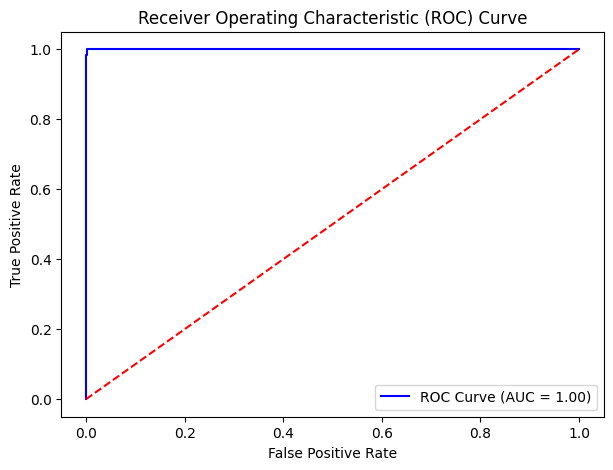

In [12]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # Random model reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()

plt.savefig('../results/result_2/ROC Curve.png')
plt.show()


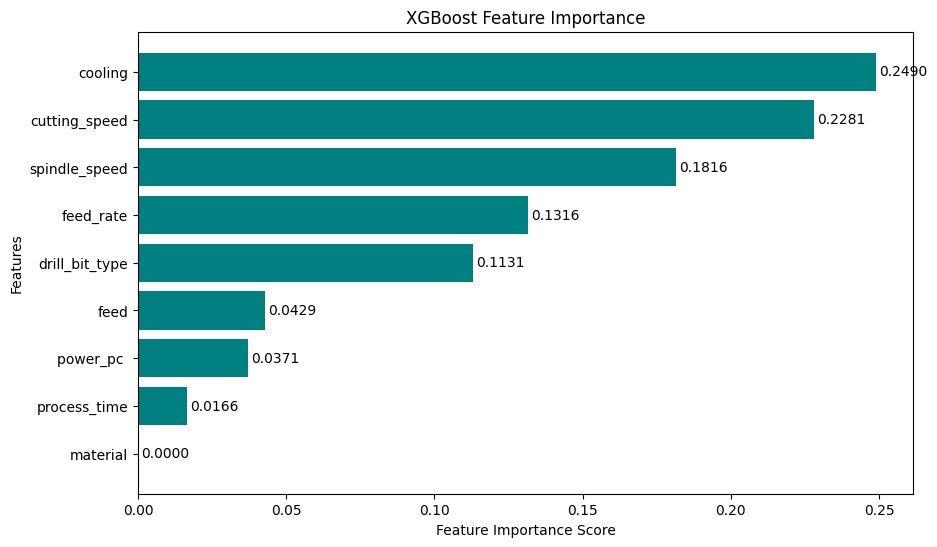

In [13]:
# Get feature importance values and feature names
importance = model.feature_importances_
features = model.get_booster().feature_names

# Sort features by importance
sorted_idx = np.argsort(importance)

# Plot feature importance with values
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], importance[sorted_idx], color="teal")
for i, v in enumerate(importance[sorted_idx]):
    plt.text(v + 0.001, i, f"{v:.4f}", va="center", fontsize=10)

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")

plt.savefig('../results/result_2/XGBoost Feature Importance.png')
plt.show()

In [14]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

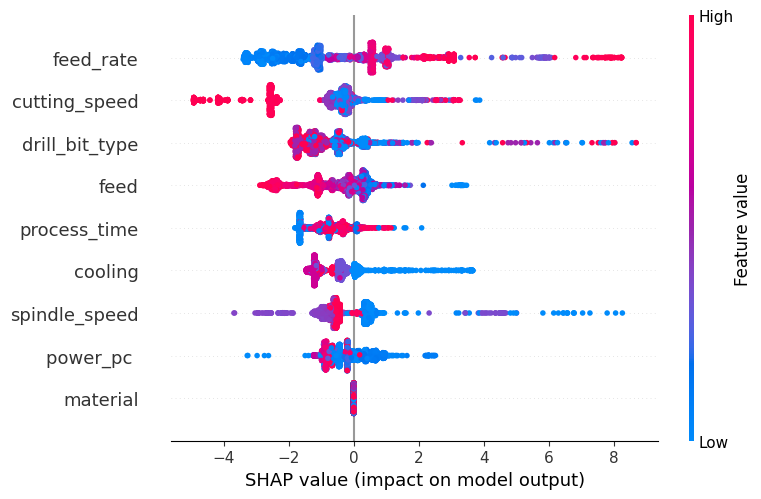

<Figure size 640x480 with 0 Axes>

In [16]:
# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test)
plt.savefig('../results/result_2/shap_summary.png')

In [17]:
# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

In [18]:
# Add the predicted output and actual output for comparison
shap_df['Predicted'] = model.predict(X_test)
shap_df['Actual'] = y_test.reset_index(drop=True)

In [19]:
# Display the first few rows
print(shap_df.head())

   cutting_speed  spindle_speed      feed  feed_rate  power_pc    cooling  \
0      -0.131372       0.492173 -2.484881   0.975495   0.521512 -1.393426   
1      -0.094019      -0.911507 -0.127591  -2.497602  -0.329689  0.151693   
2      -0.292166      -1.151208  0.107943  -3.106248   0.901820  0.031079   
3      -0.279512       0.348899 -2.193431  -1.146889  -0.022587 -0.458977   
4      -2.539808      -0.464636 -0.664332   0.973238  -0.737293 -1.165358   

   material  drill_bit_type  process_time  Predicted  Actual  
0       0.0       -1.471745     -0.287914          0       0  
1       0.0       -1.739637      0.059340          0       0  
2       0.0       -1.770449     -0.584554          0       0  
3       0.0       -1.784317     -1.129867          0       0  
4       0.0       -0.252072     -1.687092          0       0  


In [20]:
# Calculate mean absolute SHAP values for each feature
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)
print("Mean Absolute SHAP Values:")
print(mean_shap_values)

Mean Absolute SHAP Values:
feed_rate         1.705718
cutting_speed     1.132921
drill_bit_type    1.075051
feed              0.782234
process_time      0.778286
cooling           0.735367
spindle_speed     0.685961
power_pc          0.539341
Predicted         0.046250
Actual            0.046000
material          0.000000
dtype: float64


In [21]:
# Analyze a specific data point (e.g., the first row in the test set)
sample_index = 0
sample_shap_values = shap_df.iloc[sample_index]
print("SHAP Values for Sample Index", sample_index)
print(sample_shap_values)

SHAP Values for Sample Index 0
cutting_speed    -0.131372
spindle_speed     0.492173
feed             -2.484881
feed_rate         0.975495
power_pc          0.521512
cooling          -1.393426
material          0.000000
drill_bit_type   -1.471745
process_time     -0.287914
Predicted         0.000000
Actual            0.000000
Name: 0, dtype: float64


In [22]:
# Group SHAP values by the predicted class
grouped_shap_values = shap_df.groupby('Predicted').mean()
print("Mean SHAP Values Grouped by Predicted Class:")
print(grouped_shap_values)

Mean SHAP Values Grouped by Predicted Class:
           cutting_speed  spindle_speed      feed  feed_rate  power_pc   \
Predicted                                                                 
0              -1.095116      -0.339438 -0.549022  -0.757657  -0.260192   
1               1.481731       1.430455  0.788146   3.324630   0.297690   

            cooling  material  drill_bit_type  process_time    Actual  
Predicted                                                              
0         -0.597629       0.0       -0.956317     -0.775758  0.000786  
1          1.374005       0.0        1.755301      0.006419  0.978378  


In [23]:
# Group SHAP values by the actual class
grouped_shap_values_actual = shap_df.groupby('Actual').mean()
print("Mean SHAP Values Grouped by Actual Class:")
print(grouped_shap_values_actual)

Mean SHAP Values Grouped by Actual Class:
        cutting_speed  spindle_speed      feed  feed_rate  power_pc   \
Actual                                                                 
0           -1.094404      -0.332698 -0.549165  -0.759012  -0.260780   
1            1.480962       1.300300  0.798381   3.374924   0.312919   

         cooling  material  drill_bit_type  process_time  Predicted  
Actual                                                               
0      -0.596855       0.0       -0.955494     -0.774776   0.001048  
1       1.368665       0.0        1.752963     -0.009689   0.983696  


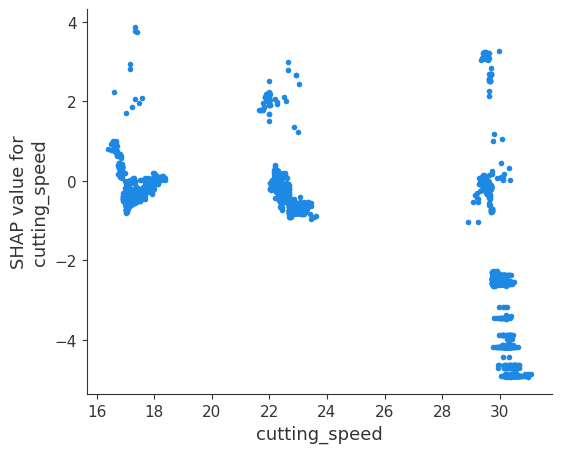

<Figure size 640x480 with 0 Axes>

In [24]:
# Visualize SHAP values for a specific feature (e.g., 'Cutting speed vc')
shap.dependence_plot('cutting_speed', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/SHAP Cutting Speed.png')

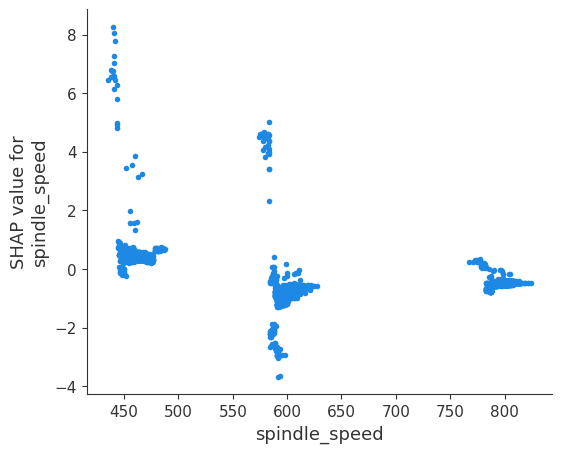

<Figure size 640x480 with 0 Axes>

In [25]:
# Visualize SHAP values for a specific feature (e.g., 'Cutting speed vc')
shap.dependence_plot('spindle_speed', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/SHAP spindle speed.png')

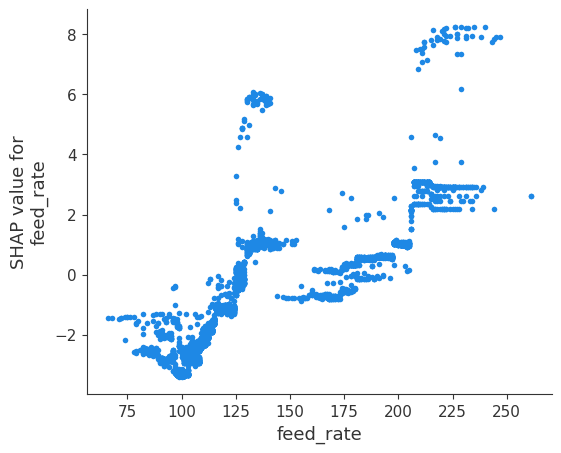

<Figure size 640x480 with 0 Axes>

In [26]:
# Visualize SHAP values for a specific feature (e.g., 'feed  feed_rate')
shap.dependence_plot('feed_rate', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/ SHAP feed rate.png')

In [28]:
# Visualize SHAP values for a specific feature (e.g., 'feed  feed_rate')
#shap.dependence_plot('power_pc', shap_values, X_test, interaction_index=None)
#plt.savefig('../results/result_2/SHAP power pc.png')

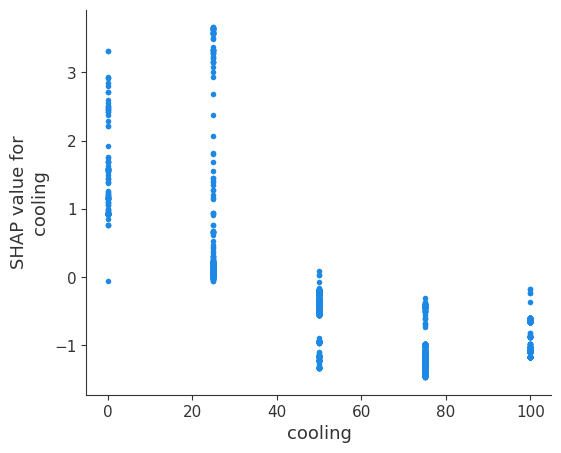

<Figure size 640x480 with 0 Axes>

In [29]:
# Visualize SHAP values for a specific feature (e.g., 'feed  feed_rate')
shap.dependence_plot('cooling', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/SHAP cooling.png')

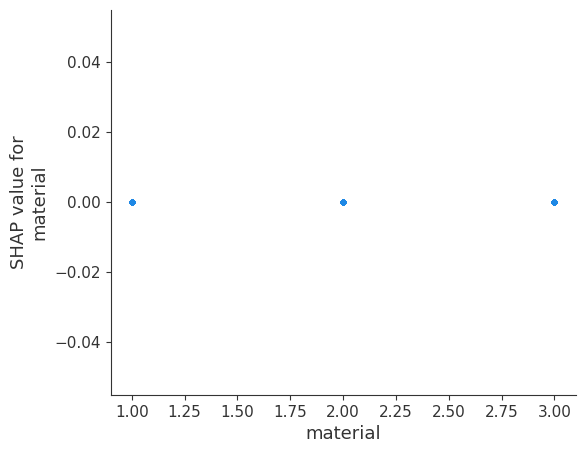

<Figure size 640x480 with 0 Axes>

In [30]:
# Visualize SHAP values for a specific feature (e.g., 'feed  feed_rate')
shap.dependence_plot('material', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/SHAP material.png')

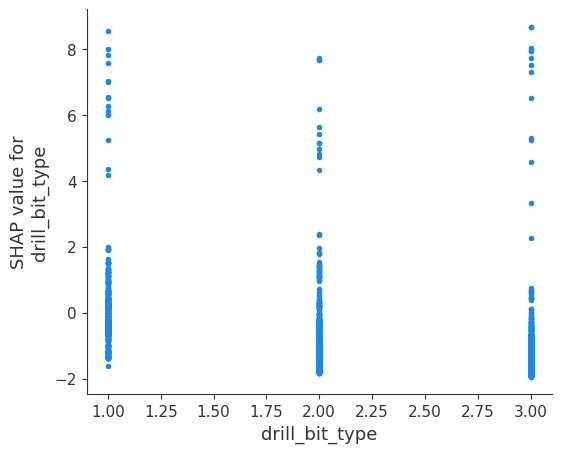

<Figure size 640x480 with 0 Axes>

In [31]:
# Visualize SHAP values for a specific feature (e.g., 'feed  feed_rate')
shap.dependence_plot('drill_bit_type', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/SHAP Drill Bit Type.png')

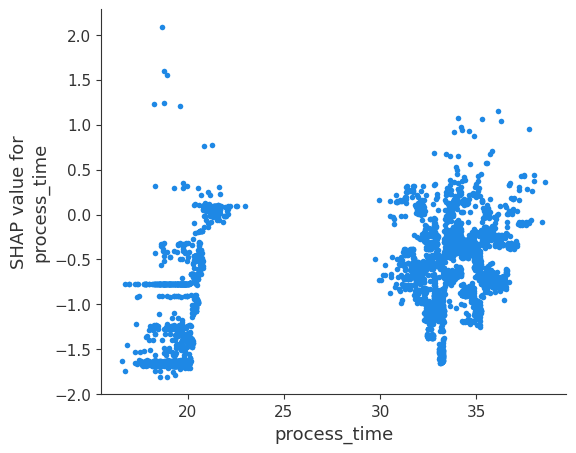

<Figure size 640x480 with 0 Axes>

In [32]:
# Visualize SHAP values for a specific feature (e.g., 'feed  feed_rate')
shap.dependence_plot('process_time', shap_values, X_test, interaction_index=None)
plt.savefig('../results/result_2/SHAP Process Time.png')

In [33]:
# Save SHAP values to a CSV file
shap_df.to_csv('shap_values.csv', index=False)

In [34]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['No Failure', 'Main Failure'], mode='classification')

In [35]:
# Explain a single instance
instance = X_test.iloc[0].values
exp = explainer.explain_instance(instance, model.predict_proba, num_features=10)
exp.show_in_notebook()

In [36]:
failure_types = ['BEF', 'CCF', 'FWF', 'WDF']
for failure in failure_types:
    y_failure = df[failure]
    X_train, X_test, y_train, y_test = train_test_split(X, y_failure, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {failure}:")
    print(classification_report(y_test, y_pred))

Classification Report for BEF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3953
           1       0.90      0.98      0.94        47

    accuracy                           1.00      4000
   macro avg       0.95      0.99      0.97      4000
weighted avg       1.00      1.00      1.00      4000

Classification Report for CCF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3928
           1       1.00      0.94      0.97        72

    accuracy                           1.00      4000
   macro avg       1.00      0.97      0.99      4000
weighted avg       1.00      1.00      1.00      4000

Classification Report for FWF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3953
           1       0.98      0.98      0.98        47

    accuracy                           1.00      4000
   macro avg       0.99      0.99  

In [37]:
# Explain a single instance
instance = X_test.iloc[0].values
exp = explainer.explain_instance(instance, model.predict_proba, num_features=10)

# Extract explanation details
lime_details = exp.as_list()
print("LIME Explanation for the Instance:")
for feature, weight in lime_details:
    print(f"{feature}: {weight}")

LIME Explanation for the Instance:
467.00 < spindle_speed <= 600.00: -0.11417685341933596
122.00 < feed_rate <= 184.00: -0.103274341200054
2.00 < drill_bit_type <= 3.00: -0.09090918920294516
17.60 < cutting_speed <= 22.61: 0.03798272835456112
78.58 < power_pc  <= 93.36: 0.01678354317371858
feed > 0.25: 0.016162463755001237
32.95 < process_time <= 34.52: -0.007904586819098704
50.00 < cooling <= 75.00: -0.004458699978791293
2.00 < material <= 3.00: 0.002744751960443936


In [38]:
# Visualize the explanation
exp.show_in_notebook()

In [39]:
# Analyze multiple instances
for i in range(5):  # Analyze the first 5 instances
    instance = X_test.iloc[i].values
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=10)
    print(f"\nExplanation for Instance {i}:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight}")


Explanation for Instance 0:
467.00 < spindle_speed <= 600.00: -0.12168656376536585
122.00 < feed_rate <= 184.00: -0.090681783234446
2.00 < drill_bit_type <= 3.00: -0.07640333104131411
17.60 < cutting_speed <= 22.61: 0.06563311900326407
50.00 < cooling <= 75.00: 0.027639965034731723
32.95 < process_time <= 34.52: -0.025731422354753456
78.58 < power_pc  <= 93.36: 0.0170200647531026
feed > 0.25: -0.012695058842001746
2.00 < material <= 3.00: -0.005622260380890994

Explanation for Instance 1:
feed_rate <= 110.00: 0.1501096262809085
1.00 < drill_bit_type <= 2.00: -0.11896598995561435
467.00 < spindle_speed <= 600.00: -0.10028839958660553
feed <= 0.19: -0.049265666027163785
78.58 < power_pc  <= 93.36: 0.04767081602776755
17.60 < cutting_speed <= 22.61: 0.0363412459286406
cooling <= 50.00: -0.01963411956500712
process_time > 34.52: 0.0147772929826567
1.00 < material <= 2.00: -0.0133890707521902

Explanation for Instance 2:
feed_rate <= 110.00: 0.17261126929591067
1.00 < drill_bit_type <= 2.0

In [40]:
# Aggregate LIME explanations
feature_weights = {}

for i in range(len(X_test)):  # Analyze all instances in the test set
    instance = X_test.iloc[i].values
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=10)
    for feature, weight in exp.as_list():
        if feature in feature_weights:
            feature_weights[feature].append(weight)
        else:
            feature_weights[feature] = [weight]

# Calculate mean absolute weights for each feature
mean_feature_weights = {feature: np.mean(np.abs(weights)) for feature, weights in feature_weights.items()}
sorted_features = sorted(mean_feature_weights.items(), key=lambda x: x[1], reverse=True)

print("\nMean Absolute Feature Weights:")
for feature, weight in sorted_features:
    print(f"{feature}: {weight}")


Mean Absolute Feature Weights:
spindle_speed > 790.00: 0.27059910315568797
feed_rate > 184.00: 0.17499701364689346
feed_rate <= 110.00: 0.16730055583490905
drill_bit_type <= 1.00: 0.14351193775603752
cutting_speed <= 17.60: 0.1357466481119192
spindle_speed <= 467.00: 0.13241776491144963
1.00 < drill_bit_type <= 2.00: 0.11522581039481494
22.61 < cutting_speed <= 29.78: 0.11004323996283383
467.00 < spindle_speed <= 600.00: 0.1074029333637824
cutting_speed > 29.78: 0.10599381523779258
122.00 < feed_rate <= 184.00: 0.10254363091489833
110.00 < feed_rate <= 122.00: 0.09562648717370219
2.00 < drill_bit_type <= 3.00: 0.08910667785343032
17.60 < cutting_speed <= 22.61: 0.04486206544398744
feed <= 0.19: 0.031059157791564065
600.00 < spindle_speed <= 790.00: 0.030830763636076695
process_time <= 20.34: 0.02220320947936144
process_time > 34.52: 0.021481472750457784
power_pc  > 203.70: 0.017083186469714056
cooling > 75.00: 0.01610782828306862
78.58 < power_pc  <= 93.36: 0.015099776553261168
20.34 

In [41]:
# Save LIME explanations to a JSON file
lime_explanations = []
for i in range(len(X_test)):
    instance = X_test.iloc[i].values
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=10)
    lime_explanations.append(exp.as_list())

with open('lime_explanations.json', 'w') as f:
    json.dump(lime_explanations, f)

In [42]:
# Explain an instance with feature interactions
exp = explainer.explain_instance(instance, model.predict_proba, num_features=10, top_labels=1)

# Get the explanation for the top predicted class
label = exp.available_labels()[0]
print(f"Explanation for Class {label}:")
for feature, weight in exp.as_list(label):
    print(f"{feature}: {weight}")

Explanation for Class 0:
spindle_speed > 790.00: -0.274874491171287
feed_rate > 184.00: 0.15793513805361573
drill_bit_type <= 1.00: -0.1336829498979217
cutting_speed > 29.78: 0.09863705820648701
power_pc  > 203.70: 0.027134909203925108
0.23 < feed <= 0.25: -0.01862740275289079
process_time <= 20.34: -0.010412060956014052
50.00 < cooling <= 75.00: -0.006754199397717423
material <= 1.00: -0.0024220653872551227
